# Fermion Chain to Boson Chain

To properly work with Qutip we have to figure out how to incorporate fermions since there is no dedicated operator for that in this toolbox. There are however boson operators. Therefore **we can just use Jorda-Wigner transforms to express our fermionic operators (even with spins, we have to figure that one out) in terms of the JW string times a bosoni operator**. This is what we do here

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

from qutip import  *

# 1D-Hopping Chain

In [11]:
L = 6 # Num of sites
D = 2 # local hilbert space
gamma = 0.2 # the dephasing term for the collapse operators
max_t = 30 # maximum time
tsteps = 300 # number of time steps
J = np.ones(L) # interaction
# Here we could place a a point contact if we want
J[L-4] = 1
J[L-3] = 1

b = destroy(2) # annihilation

initial_conditions = np.zeros(L**2) # initial conditions of the density matrix
initial_conditions[0] = 1.0

J

array([1., 1., 1., 1., 1., 1.])

In [ ]:
def create_fermion_op(Nsites):
    # create fermions from quspin bosons and JW strings
    C_list = []
    for site_j in range(0,L):
        # create the string
        JW_string = [identity(2)]*L
        for l in range(0,site_j):
            JW_string[l] = (1j*np.pi*b.dag()*b).expm()
        JW_string[site_j] = b
        # tensor product the string to get the new fermion operator at site_j
        C_list.append(tensor(JW_string))
    return C_list

In [4]:
# create the hamiltonian in terms of the fermion operators
ident_tensor = tensor([identity(D)]*L) 
H = 0*ident_tensor

for site_j in range(0,L-1):
    H += -0.5*J[site_j]*(c_list[site_j].dag()*c_list[site_j+1]+c_list[site_j+1].dag()*c_list[site_j] )

H

Quantum object: dims=[[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]], shape=(64, 64), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.   0.  -0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  0.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.  -0.5  0. ]
 [ 0.   0.   0.  ... -0.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]]

In [5]:
# create the collapse and expectation value operators
collapse_ops = []
expect_ops = []

for site_j in range(0,L):
    density_op = c_list[site_j].dag()*c_list[site_j]
    # cj+1^dagger cj
    collapse_ops.append(np.sqrt(gamma)*density_op)
    # cj^dagger*cj+1
    expect_ops.append(density_op)
   
# add the energy at the end
expect_ops.append(H)

In [6]:
# now initialize the density matrix
basis_list = []

# Create the basis vectors, for this case there is a !!single!! spin up
for site in range(0,L):
    # initialize everything in down state
    single_state_list = [basis(D,0)]*L
    # flip the spin up the spin in site
    single_state_list[site] = basis(D,1)
    # notice how there is only one spin up (one particle states)
    ket = tensor(single_state_list)
    basis_list.append(ket)

# initialize the density matrix
# make all possible 2 elemet combinations where order matters so we can get the density matrix
combination_list = list(itertools.product(basis_list, basis_list))

# initialize a density matrix object that is full of zeros
rho = 0*combination_list[0][0]*combination_list[0][1].dag()

# build the density matrix
for i in range(0,len(combination_list)):
    rho += initial_conditions[i]*combination_list[i][0]*combination_list[i][1].dag()
    
rho

Quantum object: dims=[[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]], shape=(64, 64), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [7]:
times = np.linspace(0.0, max_t, tsteps)

result = mesolve(H, rho, times, c_ops=collapse_ops , e_ops=expect_ops)

result

<Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.00021505355834960938
    preparation time: 0.0007648468017578125
    run time: 4.049969911575317
    solver: 'Master Equation Evolution'
    num_collapse: 6
  Time interval: [0.0, 30.0] (300 steps)
  Number of e_ops: 7
  State not saved.
>

Text(0, 0.5, 'Energy')

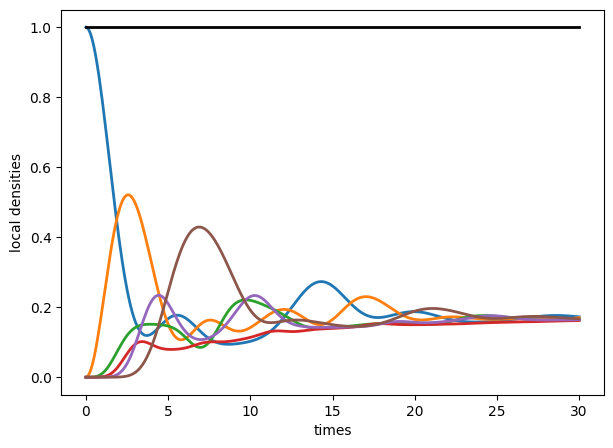

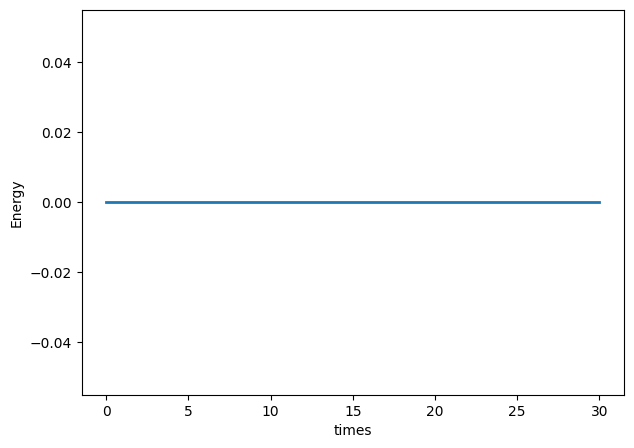

In [8]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# plot
for i in range(0,len(result.expect)-1):
    ax.plot(times, result.expect[i], linewidth=2.0)
    
# get the total particle number
# get the sum of the local densities
n_tot = np.sum(result.expect, axis=0)
ax.plot(times, n_tot, c='black', linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("local densities")

fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(times, result.expect[-1], linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("Energy")

# With Point Contact

# With Gaussian initial state